In [ ]:
!pip install inference-sdk opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.13.0
    Uninstalling aiohttp-3.13.0:
      Successfully uninstalled aiohttp-3.13.0


In [ ]:
import cv2
import requests
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from inference_sdk import InferenceHTTPClient
from google.colab import userdata


In [ ]:
roboflow_api_key = userdata.get('roboflow_api_key')

Processing image: /content/brownclassic_camera_149.jpg
Board successfully warped.
Cropped chessboard saved to /content/cropped-chessboard.jpg


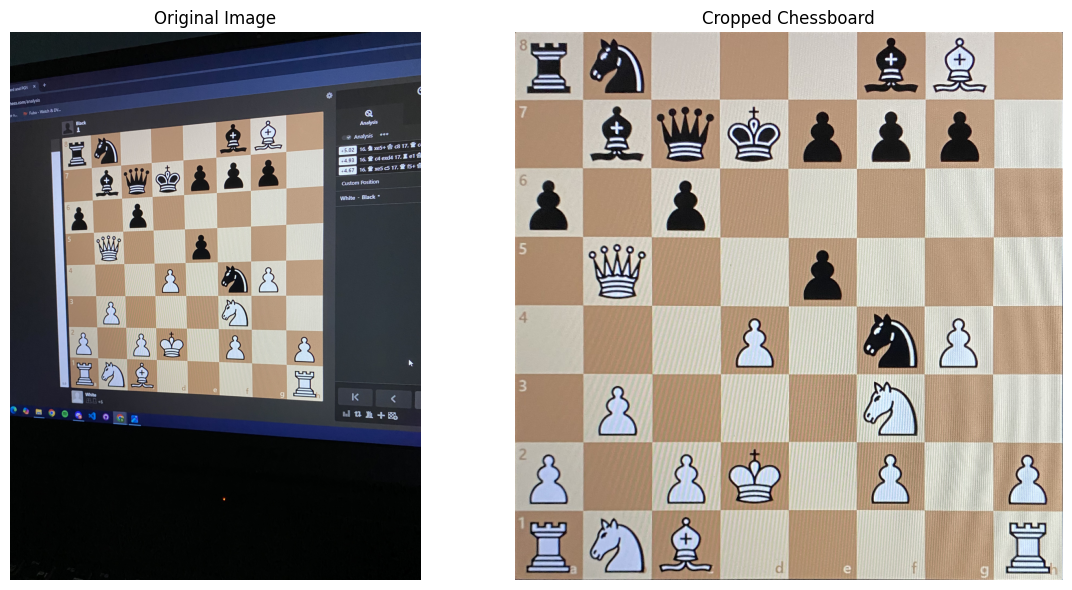

In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def detect_and_warp_board_contour(image_path, output_size=(800, 800)):
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        print("Failed to load image.")
        return None, None

    orig = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)
    edged = cv2.dilate(edged, None, iterations=2)
    edged = cv2.erode(edged, None, iterations=2)

    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found.")
        return None, orig

    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    board_contour = None
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            board_contour = approx
            break

    if board_contour is None:
        print("No quadrilateral contour found.")
        return None, orig

    pts = board_contour.reshape(4, 2)
    rect = order_points(pts)
    dst = np.array([
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1],
        [0, output_size[1] - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(orig, M, output_size)
    print("Board successfully warped.")
    return warped, orig

# === Find the first image in /content ===
img_extensions = ['*.jpg', '*.jpeg', '*.png']
all_images = []
for ext in img_extensions:
    all_images.extend(glob.glob(f"/content/{ext}"))

if not all_images:
    print("No image files found in /content.")
else:
    image_path = all_images[0]
    cropped_output_path = "/content/cropped-chessboard.jpg"
    cropped, original = detect_and_warp_board_contour(image_path)

    if cropped is not None:
        cv2.imwrite(cropped_output_path, cropped)
        print(f"Cropped chessboard saved to {cropped_output_path}")

        # === Visualization ===
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Cropped Chessboard")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
# Path to uploaded file
image_path = "/content/cropped-chessboard.jpg"  # Make sure this is uploaded via sidebar

# Roboflow inference
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key=roboflow_api_key
)

result = CLIENT.infer(image_path, model_id="chessbot-v2/1")
predictions = result['predictions']

NameError: name 'roboflow_api_key' is not defined

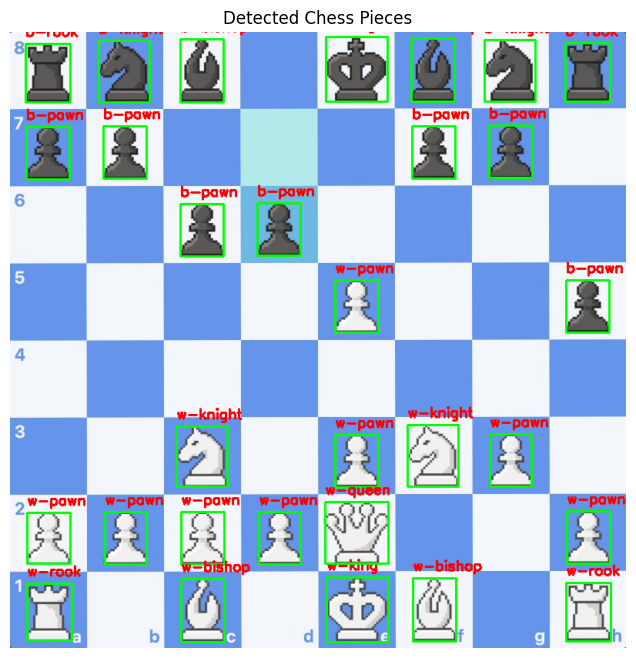

In [ ]:
# Load and convert image for display
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw predictions
for pred in predictions:
    x, y, w, h = int(pred['x']), int(pred['y']), int(pred['width']), int(pred['height'])
    class_name = pred['class']

    top_left = (x - w // 2, y - h // 2)
    bottom_right = (x + w // 2, y + h // 2)

    cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(img, class_name, (top_left[0], top_left[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Detected Chess Pieces")
plt.axis("off")
plt.show()

In [ ]:
# Square size
SQUARE_SIZE = 100
piece_map = {}

# Convert x/y to chess square
def get_square(x, y):
    file = int(x // SQUARE_SIZE)
    rank = 7 - int(y // SQUARE_SIZE)
    return chr(ord('a') + file) + str(rank + 1)

# Map pieces to board
for pred in predictions:
    square = get_square(pred['x'], pred['y'])
    label = pred['class']
    color, piece = label.split('-')
    fen_char = {
        'pawn': 'p', 'knight': 'n', 'bishop': 'b',
        'rook': 'r', 'queen': 'q', 'king': 'k'
    }[piece]
    if color == 'w':
        fen_char = fen_char.upper()
    piece_map[square] = fen_char

In [ ]:
def build_fen(piece_map):
    fen_rows = []
    for rank in range(8, 0, -1):
        row = ''
        empty = 0
        for file in 'abcdefgh':
            square = file + str(rank)
            if square in piece_map:
                if empty:
                    row += str(empty)
                    empty = 0
                row += piece_map[square]
            else:
                empty += 1
        if empty:
            row += str(empty)
        fen_rows.append(row)
    return '/'.join(fen_rows) + ' w KQkq - 0 1'

fen = build_fen(piece_map)
print("Generated FEN:", fen)

Generated FEN: rnb1kbnr/pp3pp1/2pp4/4P2p/8/2N1PNP1/PPPPQ2P/R1B1KB1R w KQkq - 0 1


In [ ]:
#replit dev mode (fast)
#res = requests.post(
    #"https://ff29b19e-2738-46ef-b0cf-7ac065539909-00-2mkze9d4wiocb.picard.replit.dev/get-best-move",
    #json={"fen": fen}
#)

#render (slow)
res = requests.post(
    "https://stockfish-api-jzrn.onrender.com/get-best-move",
    json={"fen": fen}
)

if res.ok:
    data = res.json()
    best_move_uci = data["best_move_uci"]
    best_move_san = data["best_move_san"]
    print("Best Move (SAN):", best_move_san)
    print("Best Move (UCI):", best_move_uci)
    print("Evaluation:", data["evaluation"])
else:
    print("API Error:", res.text)

Best Move (SAN): exd6
Best Move (UCI): e5d6
Evaluation: 8.50


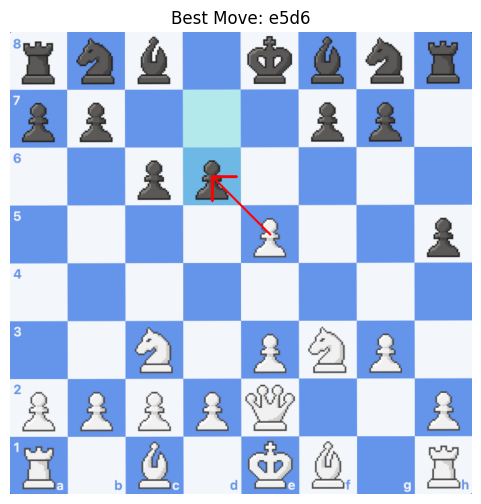

In [ ]:
def draw_move_arrow(image, move_uci):
    src_square = move_uci[:2]
    dst_square = move_uci[2:]

    def square_to_coords(square):
        file = ord(square[0]) - ord('a')
        rank = 8 - int(square[1])  # rank 1 is bottom
        x = int((file + 0.5) * 100)
        y = int((rank + 0.5) * 100)
        return (x, y)

    pt1 = square_to_coords(src_square)
    pt2 = square_to_coords(dst_square)

    img_copy = image.copy()
    cv2.arrowedLine(img_copy, pt1, pt2, (0, 0, 255), 3, tipLength=0.3)
    return img_copy

# === Step 3: Visualize the result ===
if res.ok:
    img_with_arrow = draw_move_arrow(cropped, best_move_uci)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_with_arrow, cv2.COLOR_BGR2RGB))
    plt.title(f"Best Move: {best_move_uci}")
    plt.axis("off")
    plt.show()